In [8]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
import scipy.io
import os.path
from utils import *
from run_simulations import *
from decoding import *
from agents import *
from sklearn import svm
import pickle
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from sklearn.linear_model import LinearRegression
from expfitting import *

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module='utils')


%matplotlib notebook
%reload_ext autoreload
%autoreload 2

## Repeated simulations of Q-learning and inference-based behavior 

### Q-learning

In [ ]:
# Get metrics for all points in the Qspace
N = 11
gammalst = np.linspace(0.01, 1.4, N)
epslst = np.linspace(0.01, 0.5, N)

Qeff_arr = np.zeros((N, N, 50)) * np.nan
Qlapse_arr = np.zeros((N, N, 50)) * np.nan
Qoffset_arr = np.zeros((N, N, 50)) * np.nan
Qslope_arr = np.zeros((N, N, 50)) * np.nan


for idgamma, gamma in enumerate(gammalst):
    for ideps, eps in enumerate(epslst):
        print(gamma, eps)
        metrics = get_Qmetrics(gamma, eps)
        Qeff_arr[idgamma, ideps, :] = metrics[0]
        Qlapse_arr[idgamma, ideps, :] = metrics[1]
        Qoffset_arr[idgamma, ideps, :] = metrics[2]
        Qslope_arr[idgamma, ideps, :] = metrics[3]
        

In [ ]:
plt.imshow(np.nanmean(Qeff_arr, axis=2))
plt.colorbar()

### Inference-based

In [ ]:
# Get metrics for all points in the IB space
prewlst = np.linspace(0.55, 0.99, N)
pswitchlst = np.linspace(0.01, 0.45, N)

IBeff_arr = np.zeros((N, N, 50)) * np.nan
IBlapse_arr = np.zeros((N, N, 50)) * np.nan
IBoffset_arr = np.zeros((N, N, 50)) * np.nan
IBslope_arr = np.zeros((N, N, 50)) * np.nan


for idr, prew in enumerate(prewlst):
    for ids, pswitch in enumerate(pswitchlst):
        print(prew, pswitch)
        metrics = get_IB_metrics(pswitch, prew)
        IBeff_arr[idr, ids, :] = metrics[0]
        IBlapse_arr[idr, ids, :] = metrics[1]
        IBoffset_arr[idr, ids, :] = metrics[2]
        IBslope_arr[idr, ids, :] = metrics[3]
        

### Decoding
Here, we will try to use SVM to decode the behavior of Q-learning from inference-based.
We pick pairs of parameter sets, one from Q-learning and one from inference-based, to do the decoding

In [ ]:
# SVM decode
decoding_perf = np.zeros((len(gammalst), len(epslst), len(prewlst), len(pswitchlst)))
coefs_all0 = np.zeros((len(gammalst), len(epslst), len(prewlst), len(pswitchlst)))
coefs_all1 = np.zeros((len(gammalst), len(epslst), len(prewlst), len(pswitchlst)))
coefs_all2 = np.zeros((len(gammalst), len(epslst), len(prewlst), len(pswitchlst)))
coefs_all3 = np.zeros((len(gammalst), len(epslst), len(prewlst), len(pswitchlst)))

for idgamma, gamma in enumerate(gammalst):
    for ideps, eps in enumerate(epslst):
        for idr, pr in enumerate(prewlst):
            for ids, ps in enumerate(pswitchlst):
                Qmetrics = [Qeff_arr[idgamma, ideps], Qlapse_arr[idgamma, ideps], 
                            Qoffset_arr[idgamma, ideps], Qslope_arr[idgamma, ideps]]
                IBmetrics = [IBeff_arr[idr, ids], IBlapse_arr[idr, ids], 
                            IBoffset_arr[idr, ids], IBslope_arr[idr, ids]]
                perf, coefs = fit_and_evaluate_svm(Qmetrics, IBmetrics)
                decoding_perf[idgamma, ideps, idr, ids] = perf
                coefs_all0[idgamma, ideps, idr, ids] = coefs[0][0]
                coefs_all1[idgamma, ideps, idr, ids] = coefs[0][1]
                coefs_all2[idgamma, ideps, idr, ids] = coefs[0][2]
                coefs_all3[idgamma, ideps, idr, ids] = coefs[0][3]



In [ ]:
sim_obj = {'Qeff_arr': Qeff_arr, 'Qlapse_arr': Qlapse_arr, 'Qoffset_arr': Qoffset_arr, 
          'Qslope_arr': Qslope_arr, 'IBeff_arr': IBeff_arr, 'IBlapse_arr': IBlapse_arr,
          'IBslope_arr': IBslope_arr, 'IBoffset_arr': IBoffset_arr,
          'coefs0': coefs_all0, 'coefs1': coefs_all1, 'coefs2': coefs_all2,
                                   'coefs3': coefs_all3, 'decoding_perf': decoding_perf,
                                   'prewlst': prewlst, 'pswitchlst': pswitchlst, 'gammalst': gammalst,
                                   'epslst': epslst, 'order': ['gamma', 'eps', 'pr', 'ps']}
with open('svmclassifier.pickle', 'wb') as f:
    pickle.dump(sim_obj, f)

In [ ]:
scipy.io.savemat('svmresults2.mat', {'coefs0': coefs_all0, 'coefs1': coefs_all1, 'coefs2': coefs_all2,
                                   'coefs3': coefs_all3, 'decoding_perf': decoding_perf,
                                   'prewlst': prewlst, 'pswitchlst': pswitchlst, 'gammalst': gammalst,
                                   'epslst': epslst, 'order': ['gamma', 'eps', 'pr', 'ps']})

## Behavioral session decoding

In [2]:
# Load the simulation results
with open('svmclassifier.pickle', 'rb') as f:
    sim_obj = pickle.load(f)

eff_arr_all = np.vstack([sim_obj['Qeff_arr'], sim_obj['IBeff_arr']])
lapse_arr_all = np.vstack([sim_obj['Qlapse_arr'], sim_obj['IBlapse_arr']])
offset_arr_all = np.vstack([sim_obj['Qoffset_arr'], sim_obj['IBoffset_arr']])
slope_arr_all = np.vstack([sim_obj['Qslope_arr'], sim_obj['IBslope_arr']])

In [ ]:
# Load the behavior
animal = 'e53'
filename = 'expdata/' + animal + '_all_sessions.mat'
data = scipy.io.loadmat(filename)

datarange = -1

delaystartcands = np.where(data['maxdelays'] > 0)[1]

if len(delaystartcands) == 0:
    delaystart = len(data['maxdelays'][0])
else:
    delaystart = delaystartcands[0]
print('Number of sessions before delay:', delaystart)

# Fitting for all files
qpos_all = []
ibpos_all = []

pL_all = []
pR_all = []
eff_all = []

if datarange == -1:
    datarange = np.arange(0, len(data['targets_cell'][0]))
else:
    datarange = np.arange(datarange[0], datarange[1])

# f01: 29
# f02: 29
# e50: 30
# f11: 28
# f12: 29
for i in tqdm(datarange): #tqdm(range(len(data['targets_cell'][0]))):
#     print(i)
    expdata = {'alltargets': data['targets_cell'][0][i], 
           'allchoices': data['choices_cell'][0][i]}
    
    if len(expdata['alltargets']) == 0 or len(np.unique(expdata['alltargets'])) == 1:
        qpos_all.append([-1, -1])
        ibpos_all.append([-1, -1])
        pL_all.append([np.nan] * 3)
        pR_all.append([np.nan] * 3)
        eff_all.append(np.nan)
    else:
        pR, pL, choicelst, eff = find_experiment_metrics(expdata, window=20, type='doublesigmoid')
        
        # skip if too few blocks
        if choicelst.shape[0] <= 5:
            pL_all.append([np.nan] * 3)
            pR_all.append([np.nan] * 3)
            eff_all.append(np.nan)
        else:
            pL_all.append(pL)
            pR_all.append(pR)
            eff_all.append(eff)

#         Qdistance, IBdistance, expeff, expl, expo, exps = find_Q_IB_ave_distance([eff, pL], [eff_arr_all,
#                             lapse_arr_all, offset_arr_all, slope_arr_all])
#         Qdistance, IBdistance = find_Q_IB_zdistance([eff, [pL[0], pL[0], pL[1]]], [eff_arr_all,
#                             lapse_arr_all, offset_arr_all, slope_arr_all])
#         qpos = [np.where(Qdistance == np.nanmin(Qdistance))[0][0],
#            np.where(Qdistance == np.nanmin(Qdistance))[1][0]]
#         ibpos = [np.where(IBdistance == np.nanmin(IBdistance))[0][0],
#                 np.where(IBdistance == np.nanmin(IBdistance))[1][0]]

#         qpos_all.append(qpos)
#         ibpos_all.append(ibpos)
    
    
    

plt.figure()
plt.subplot(121)
plt.imshow(choicelst[::2,:])

plt.subplot(122)
plt.plot(np.nanmean(choicelst[::2,:], axis=0))

In [ ]:
leftAverage = np.nanmean(choicelst[1::2,:], axis=0)
rightAverage = np.nanmean(choicelst[::2,:], axis=0)
offsets = np.arange(len(leftAverage))
p = fit_doublesigmoid_helper(leftAverage, rightAverage)
errordoublesigmoid(p, offsets, 1-rightAverage, offsets, leftAv)

In [ ]:
pL_all, pR_all, eff_all = fit_animal('f01')

### Visualizing single session fits

In [4]:
type = 'doublesigmoid'
if type == 'sigmoid':
    evalfun = predict_sigmoid
else:
    evalfun = exp_fun2
    
animal = 'f01'
filename = 'expdata/' + animal + '_all_sessions.mat'
data = scipy.io.loadmat(filename)

@interact(i=(0, 50))
def explore_data(i=20):
    expdata = {'alltargets': data['targets_cell'][0][i], 
               'allchoices': data['choices_cell'][0][i]}

    first_side=1-expdata['alltargets'][0][0]
    pR, pL, choicelst, eff = find_experiment_metrics(expdata, window=20, type=type)
    print('nblocks:', choicelst.shape[0])
    print('slope, offset L, lapse low', pL)
    print('slope, offset R, lapse high', pR)
    plt.figure()
    plt.subplot(122)
    xvals = np.arange(choicelst.shape[1])

    if type == 'sigmoid':
        plt.plot(1-np.nanmean(1 - choicelst[first_side::2,:], axis=0))
    elif type == 'exponential':
        plt.plot(np.nanmean(1 - choicelst[first_side::2,:], axis=0))
    elif type == 'doublesigmoid':
        predR = predict_doublesigmoid(xvals, [pR[0], pR[1], pL[2], pR[2]])
        plt.plot(np.nanmean(choicelst[1-first_side::2,:], axis=0))
        plt.plot(1-predR)
    plt.ylim([0, 1])
    plt.title('Right fit')

    plt.subplot(121)
    plt.plot(np.nanmean(choicelst[first_side::2,:], axis=0))
    if type == 'doublesigmoid':
        predL = predict_doublesigmoid(xvals, [pL[0], pL[1], pR[2], pL[2]])
        plt.plot(xvals, predL)

#     ypred = evalfun(xvals, pL)
    plt.ylim([0, 1])
    plt.title('Left fit')


interactive(children=(IntSlider(value=20, description='i', max=50), Output()), _dom_classes=('widget-interact'…

  8%|▊         | 9/113 [00:00<00:01, 71.99it/s]

Number of sessions before delay: 29


100%|██████████| 113/113 [00:03<00:00, 35.45it/s]
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expfitting.py:67: RuntimeWarning: Mean of empty slice
  maxlapses = np.nanmax(lapses, axis=0)
/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expfitting.py:68: RuntimeWarning: All-NaN slice encountered
  


<IPython.core.display.Javascript object>


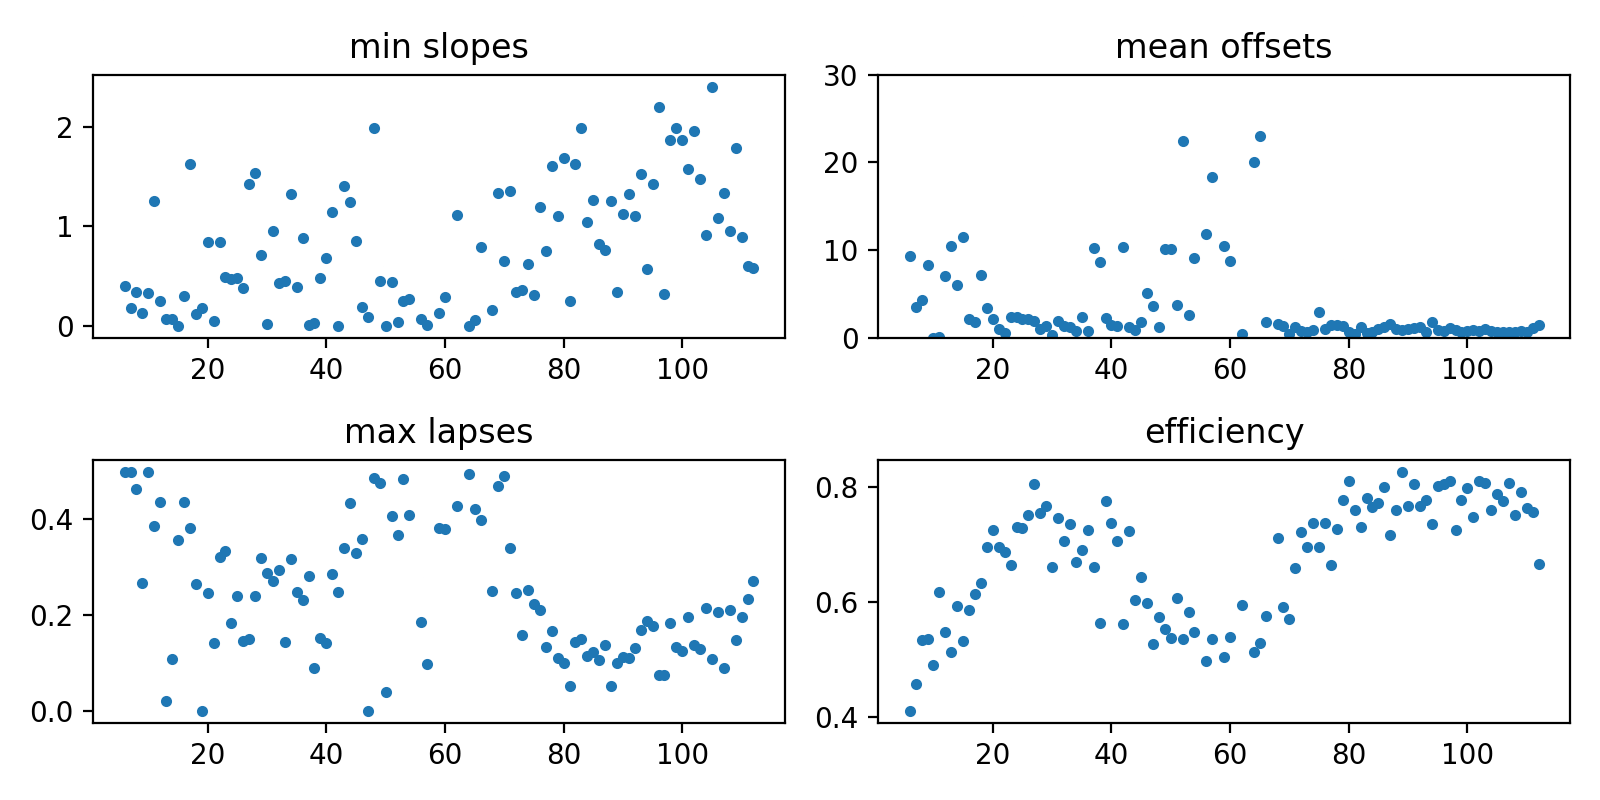

In [9]:
fitparams = fit_animal('f01')
plot_fitvals(fitparams)


In [ ]:
# Curve fitting for slopes, offsets and lapses
xvalspred = np.arange(len(minslopes))
# slopes
xfitvalsS = np.arange(len(minslopes)).reshape((-1, 1))
xfitvalsS = xfitvalsS[(~np.isnan(minslopes)) & (minslopes > 0)]
yfitvalsS = np.log(minslopes[(~np.isnan(minslopes)) & (minslopes > 0)])
regS = LinearRegression().fit(xfitvalsS, yfitvalsS)
predS = np.exp(xvalspred * regS.coef_[0] + regS.intercept_)

# offsets
xfitvalsO = np.arange(len(meanoffsets)).reshape((-1, 1))
xfitvalsO = xfitvalsO[(~np.isnan(meanoffsets)) & (meanoffsets > 0)]
yfitvalsO = np.log(meanoffsets[(~np.isnan(meanoffsets)) & (meanoffsets > 0)])
regO = LinearRegression().fit(xfitvalsO, yfitvalsO)
predO = np.exp(xvalspred * regO.coef_[0] + regO.intercept_)

# lapses
xfitvalsL = np.arange(len(maxlapses)).reshape((-1, 1))
xfitvalsL = xfitvalsL[(~np.isnan(maxlapses)) & (maxlapses > 0)]
yfitvalsL = np.log(maxlapses[(~np.isnan(maxlapses)) & (maxlapses > 0)])
regL = LinearRegression().fit(xfitvalsL, yfitvalsL)
predL = np.exp(xvalspred * regL.coef_[0] + regL.intercept_)

# efficiencies
xfitvalsE = np.arange(len(eff_all)).reshape((-1,1))
yfitvalsE = eff_all.reshape((-1,1))
regE = LinearRegression().fit(xfitvalsE, yfitvalsE)
predE = xvalspred * regE.coef_[0] + regE.intercept_




In [ ]:
plt.figure(figsize=(7,10))
plt.subplot(421)
plt.plot(np.log(minslopes))
plt.plot(xfitvalsS, yfitvalsS, '.')
plt.plot(xfitvalsS, xfitvalsS * regS.coef_[0] + regS.intercept_)
plt.title('slopes')

plt.subplot(422)
plt.plot(minslopes, '.')
plt.plot(xvalspred, predS)

plt.subplot(423)
plt.plot(np.log(meanoffsets))
plt.plot(xfitvalsO, yfitvalsO, '.')
plt.plot(xfitvalsO, xfitvalsO * regO.coef_[0] + regO.intercept_)
plt.title('offsets')

plt.subplot(424)
plt.plot(meanoffsets, '.')
plt.plot(xvalspred, predO)


plt.subplot(425)
plt.plot(np.log(maxlapses))
plt.plot(xfitvalsL, yfitvalsL, '.')
plt.plot(xfitvalsL, xfitvalsL * regL.coef_[0] + regL.intercept_)
plt.title('lapses')

plt.subplot(426)
plt.plot(maxlapses, '.')
plt.plot(xvalspred, predL)

plt.subplot(427)
# plt.plot(np.log(maxlapses))
# plt.plot(xfitvalsL, yfitvalsL, '.')
# plt.plot(xfitvalsL, xfitvalsL * regL.coef_[0] + regL.intercept_)

# plt.subplot(428)
plt.plot(eff_all, '.')
plt.plot(xvalspred, predE)
plt.title('efficiencies')
plt.tight_layout()

In [ ]:
in_percentile

In [ ]:
in_percentile(eff_arr_all, 0.8)

In [ ]:
in_percentile([1,2,3,4,5], 4)

In [ ]:
# compute Q- and IB- distance
qpos_all, ibpos_all = [], []
for i in [0]: #range(len(predO)):
    Qdistance, IBdistance = find_Q_IB_zdistance((predE[i], [predS[i], -predO[i], predL[i]]), [eff_arr_all,
                            lapse_arr_all, offset_arr_all, slope_arr_all], method='percentile')
    
    qpos = [np.where(Qdistance == np.nanmin(Qdistance))[0][0],
       np.where(Qdistance == np.nanmin(Qdistance))[1][0]]
    ibpos = [np.where(IBdistance == np.nanmin(IBdistance))[0][0],
            np.where(IBdistance == np.nanmin(IBdistance))[1][0]]

    qpos_all.append(qpos)
    ibpos_all.append(ibpos)
    
    

In [ ]:
qpos

In [ ]:
plt.figure()
plt.subplot(121)
plt.plot(np.array(qpos_all))

plt.subplot(122)
plt.plot(np.array(ibpos_all))

In [ ]:
plt.figure()
plt.imshow(slopes, aspect='auto', vmin=-50, vmax=0)
plt.colorbar()
plt.tight_layout()

In [ ]:
id = 11
Qdistance, IBdistance = find_Q_IB_zdistance((predE[id], [predS[id], -predO[id], predL[id]]), [eff_arr_all,
                            lapse_arr_all, offset_arr_all, slope_arr_all])
print(np.where(Qdistance == np.min(Qdistance)), np.min(Qdistance))
plt.figure()
plt.imshow(Qdistance, vmin=0, vmax=900)
plt.colorbar()

In [ ]:
np.percentile?

In [ ]:
Qdistance

In [ ]:
id = 19
Qdistance, IBdistance, enorm, lnorm, onorm, snorm = find_Q_IB_zdistance((predE[id], [predS[id], -predO[id], predL[id]]), [eff_arr_all,
                            lapse_arr_all, offset_arr_all, slope_arr_all], method='percentile')

plt.figure()
refpoint = [0, 10]
qpos = [np.where(Qdistance == np.min(Qdistance))[0][0],
       np.where(Qdistance == np.min(Qdistance))[1][0]]
# qpos = [9,1]
ibpos = [np.where(IBdistance == np.min(IBdistance))[0][0],
        np.where(IBdistance == np.min(IBdistance))[1][0]]
print('qpos = ', qpos, '. ibpos =', ibpos)
plt.subplot(221)
plt.plot(sim_obj['Qeff_arr'][qpos[0], qpos[1]])
plt.plot(sim_obj['Qeff_arr'][refpoint[0], refpoint[1]])
# plt.plot(sim_obj['IBeff_arr'][ibpos[0], ibpos[1]])
plt.title('Efficiency')
plt.hlines(predE[id], 0, 50)

plt.subplot(222)
plt.plot(sim_obj['Qlapse_arr'][qpos[0], qpos[1]])
plt.plot(sim_obj['Qlapse_arr'][refpoint[0], refpoint[1]])
# plt.plot(sim_obj['IBlapse_arr'][ibpos[0], ibpos[1]])
plt.title('Lapse')
plt.hlines(predL[id], 0, 50)


plt.subplot(223)
plt.plot(sim_obj['Qslope_arr'][qpos[0], qpos[1]])
plt.plot(sim_obj['Qslope_arr'][refpoint[0], refpoint[1]])
# plt.plot(sim_obj['IBslope_arr'][ibpos[0], ibpos[1]])
plt.title('slope')
plt.ylim([0,10])
plt.hlines(predS[id], 0, 50)


plt.subplot(224)
plt.plot(sim_obj['Qoffset_arr'][qpos[0], qpos[1]])
plt.plot(sim_obj['Qoffset_arr'][refpoint[0], refpoint[1]])
# plt.plot(sim_obj['IBoffset_arr'][ibpos[0], ibpos[1]])
plt.title('offset')
plt.hlines(-predO[id], 0, 50)
# plt.ylim([-10,0])

plt.tight_layout()


In [ ]:
print('enorm:', enorm[:11,:][9,0], enorm[:11,:][0,10])
print('snorm:', snorm[:11,:][9,0], snorm[:11,:][0,10])
print('onorm:', onorm[:11,:][9,0], onorm[:11,:][0,10])
print('lnorm:', lnorm[:11,:][9,0], lnorm[:11,:][0,10])